# linear regression

### 00 | setting up

In [2]:
import pandas as pd
import numpy as np 
import os
import janitor
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
path = r'/Users/johntam/cf_data_analysis/tasks/A6/code'

eu_data = pd.read_csv(os.path.join(path,'eu_data.csv'))

In [3]:
eu_data.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,weekends,city
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,0,amsterdam
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,0,amsterdam
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,0,amsterdam
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,0,amsterdam
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,0,amsterdam


### 01 data preprocessing 

In [7]:
# switching out boolean values for the regression

eu_data.replace({False: 0, True: 1},inplace=True)

In [6]:
eu_data.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,weekends,city
0,194.033698,Private room,0,1,2.0,0,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,0,amsterdam
1,344.245776,Private room,0,1,4.0,0,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,0,amsterdam
2,264.101422,Private room,0,1,2.0,0,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,0,amsterdam
3,433.529398,Private room,0,1,4.0,0,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,0,amsterdam
4,485.552926,Private room,0,1,2.0,1,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,0,amsterdam


In [9]:
eu_data.columns

Index(['realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat', 'weekends', 'city'],
      dtype='object')

In [5]:
# removing outliers from realSum column

q1 = eu_data.realSum.quantile(0.25)
q3 = eu_data.realSum.quantile(0.75)
iqr = q3-q1

reg_data = eu_data = eu_data[(eu_data['realSum'] >= q1 - 1.5 * iqr) & (eu_data['realSum'] <= q3 + 1.5 * iqr)]


In [10]:
reg_data.room_type.value_counts()

Entire home/apt    29336
Private room       18345
Shared room          364
Name: room_type, dtype: int64

In [8]:
# creating dummy variables for city and room variables

reg_data = reg_data.drop(['room_private','room_shared','attr_index_norm','rest_index_norm'], axis=1) # these variables are unneeded as the former will be recreated and the latter is not necessary for we will scale our factors later

reg_data = (pd.concat([reg_data, pd.get_dummies(reg_data[['city','room_type']], drop_first=True)], axis=1)
    .clean_names()
    .drop(['room_type','city'],axis = 1)
    .reset_index(drop = True)
)

In [30]:
reg_data.head()

,realsum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,...,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,room_type_private_room,room_type_shared_room
0,194.033698,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,...,0,0,0,0,0,0,0,0,1,0
1,344.245776,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,...,0,0,0,0,0,0,0,0,1,0
2,264.101422,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,...,0,0,0,0,0,0,0,0,1,0
3,433.529398,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,...,0,0,0,0,0,0,0,0,1,0
4,215.124317,2.0,0,0,0,10.0,94.0,1,1.881092,0.729747,...,0,0,0,0,0,0,0,0,1,0


In [9]:
# scaling features

features_to_scale = ['person_capacity','cleanliness_rating','guest_satisfaction_overall','bedrooms','dist','metro_dist','attr_index','rest_index']

for feature in features_to_scale:
    reg_data[feature] = MinMaxScaler(feature_range=(0, 1)).fit_transform(reg_data[[feature]])

### 02 | linear regression

In [39]:
reg_data.columns

Index(['realsum', 'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'rest_index', 'lng', 'lat', 'weekends',
       'city', 'city_athens', 'city_barcelona', 'city_berlin', 'city_budapest',
       'city_lisbon', 'city_london', 'city_paris', 'city_rome', 'city_vienna',
       'room_type_private_room', 'room_type_shared_room'],
      dtype='object')

In [55]:
# defining independent and dependent variables

y = reg_data['realsum']

X = reg_data.drop(['lat','lng','realsum'], axis = 1)


In [51]:
# using VIF to avoid multicolinearity

# calculate VIF for each independent variable
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                     variables         VIF
0              person_capacity    3.389148
1            host_is_superhost    1.534921
2                        multi    1.942135
3                          biz    2.277121
4           cleanliness_rating  126.040793
5   guest_satisfaction_overall  135.010436
6                     bedrooms    6.800298
7                         dist    8.201563
8                   metro_dist    2.769986
9                   attr_index    9.645917
10                  rest_index   12.680641
11                    weekends    2.012029
12                 city_athens    4.949167
13              city_barcelona    2.931102
14                 city_berlin    2.762703
15               city_budapest    3.894790
16                 city_lisbon    5.113162
17                 city_london    7.543735
18                  city_paris    4.991546
19                   city_rome    9.199122
20                 city_vienna    3.470914
21      room_type_private_room    2.836604
22       ro

In [56]:
# we have some crazy VIF factors so we will be removing some variables

X = X.drop(['guest_satisfaction_overall','rest_index','cleanliness_rating'], axis = 1)

In [57]:
# looking at VIF again
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                 variables       VIF
0          person_capacity  3.386005
1        host_is_superhost  1.440455
2                    multi  1.935191
3                      biz  2.237718
4                 bedrooms  6.585488
5                     dist  7.333810
6               metro_dist  2.726264
7               attr_index  4.441270
8                 weekends  1.995433
9              city_athens  2.154088
10          city_barcelona  2.010706
11             city_berlin  1.798919
12           city_budapest  1.834693
13             city_lisbon  2.467320
14             city_london  4.687062
15              city_paris  2.521947
16               city_rome  4.842150
17             city_vienna  1.763909
18  room_type_private_room  2.752557
19   room_type_shared_room  1.030691


In [58]:
# splitting data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [69]:
# running the regression 

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()

y_predicted = model.predict(X_test)

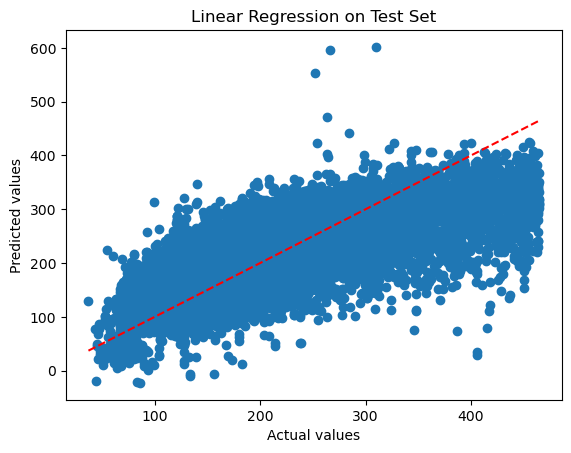

In [70]:
plt.scatter(y_test, y_predicted)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Linear Regression on Test Set')
plt.show()

In [68]:
# looking at model summary statistics 

summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realsum   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     1911.
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        11:09:22   Log-Likelihood:            -1.7730e+05
No. Observations:               31922   AIC:                         3.546e+05
Df Residuals:                   31901   BIC:                         3.548e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    349.5269      2.727    128.160      0.000     344.181     354.872
person_capacity           57.0891      1.594     35.807      0.000      53.964      60.214
host_is_superhost          6.9064      0.816      8.459      0.000       5.306       8.507
multi                      7.9138      0.891      8.883      0.000       6.168       9.660
biz                       18.7666      0.902     20.795      0.000      16.998      20.535
bedrooms                 188.0024      7.314     25.706      0.000     173.667     202.337
dist                    -104.6548      6.165    -16.975      0.000    -116.739     -92.570
metro_dist               -26.6389      7.333     -3.633      0.000     -41.012     -12.266
attr_index               428.7290     10.207     42.005      0.000     408.724     448.734
weekends                   5.6260      0.701      8.022      0.000       4.251       7.001
city_athens             -267.8120      2.658   -100.764      0.000    -273.021    -262.603
city_barcelona          -134.4774      2.827    -47.563      0.000    -140.019    -128.936
city_berlin             -114.6957      2.852    -40.222      0.000    -120.285    -109.107
city_budapest           -242.0448      2.689    -90.005      0.000    -247.316    -236.774
city_lisbon             -167.6698      2.600    -64.484      0.000    -172.766    -162.573
city_london              -96.3438      2.557    -37.679      0.000    -101.356     -91.332
city_paris               -95.5969      2.637    -36.252      0.000    -100.765     -90.428
city_rome               -210.5835      2.534    -83.099      0.000    -215.550    -205.616
city_vienna             -161.0323      2.724    -59.109      0.000    -166.372    -155.692
room_type_private_room   -74.1781      0.947    -78.349      0.000     -76.034     -72.322
room_type_shared_room   -146.5630      3.926    -37.335      0.000    -154.257    -138.869
==============================================================================
Omnibus:                     3634.711   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5652.317
Skew:                           0.828   Prob(JB):                         0.00
Kurtosis:                       4.228   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
mse = mean_squared_error(y_test, y_predicted)
print("Mean squared error:", mse)

Mean squared error: 3883.766750240806


###### although we have a solid Durbin-Watson score, we can see both from the plot and from our mse that our regression model does not fit the data well. It looks like our model tended to over estimate lower cost airbnbs and under estimate high cost airbnbs

In [73]:
# looking at predicted and actual values

data = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
data.head(30)

,Actual,Predicted
18082,102.720450,146.271477
41711,381.315316,288.440495
28565,224.391835,319.317448
24317,360.779887,280.385366
22138,126.766857,224.526988
40794,188.436631,220.267814
27778,429.219878,328.300695
28567,378.646659,316.836920
25244,445.918295,336.033809
5013,120.450871,161.153628


In [10]:
# exporting out reg_data for future use

reg_data.to_csv(os.path.join(path,'machine_data.csv'))

### 03 | lasso regression

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# assume X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# instantiate the PLS regression model with 2 components
pls = PLSRegression(n_components=2)

# fit the model on the training data
pls.fit(X_train_scaled, y_train)

# predict the target variable for the test data
y_pred = pls.predict(X_test_scaled)

# calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
